In [19]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils
import opt

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)


In [20]:
def error_to_csv(fname, models, xaxis, error):
    header = ''
    data = error

    if xaxis is not None:
        data = np.concatenate((xaxis.reshape([xaxis.size, 1]), error.T), axis=1)
        header = 'xaxis, '

    for i, model in enumerate(models):
        header += model
        if i < len(models)-1:
            header += ', '

    np.savetxt(fname, data, delimiter=',', header=header, comments='')
    print('SAVED as:', fname)


def plot_err(KK, err, ylab, logy=True, ylim=[]):
    plt.figure()
    if logy:
        plt.semilogy(KK, err[:,0], 'o:', linewidth=2, markersize=12, label='GL')
        plt.semilogy(KK, err[:,1], 'o-.', linewidth=2, markersize=12, label='GGL')
        plt.semilogy(KK, err[:,2], 'o-', linewidth=2, markersize=12, label='LVGL')
        plt.semilogy(KK, err[:,3], 'o--', linewidth=2, markersize=12, label='Joint Hidden')
    else:
        plt.plot(KK, err[:,0], 'o:', linewidth=2, markersize=12, label='GL')
        plt.plot(KK, err[:,1], 'o-.', linewidth=2, markersize=12, label='GGL')
        plt.plot(KK, err[:,2], 'o-', linewidth=2, markersize=12, label='LVGL')
        plt.plot(KK, err[:,3], 'o--', linewidth=2, markersize=12, label='Joint Hidden')

    plt.grid(True)
    plt.xlabel('Number of graphs')
    plt.ylabel(ylab)
    plt.legend()
    plt.xlim([KK[0], KK[-1]])
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()


def run_stud_Oexp(id, K, N, OO, M, regs):
    # regs_no_h = regs.copy()
    # regs_no_h['beta1'] = 1e3
    # regs_no_h['beta2'] = 0
    regs_GGL = {'rho1': 0.01, 'rho2': 0.1}
    regs_GL = {'rho1': 0.1}
    regs_LVGL = {'rho1': 0.05, 'beta1': 1}


    # Load graphs
    stud_folder = 'Student_Network_Data/'
    A_all = np.zeros((12,N,N))
    for i in range(12):
        net_list = np.loadtxt(stud_folder + 'as' + str(i+1) + '.net.txt').astype(int)
        for j in range(net_list.shape[0]):
            row = net_list[j,0]-1
            col = net_list[j,1]-1
            A_all[i,row,col] = A_all[i,col,row] = 1
    A_all = np.array(A_all)
    As = A_all[np.random.permutation(12)[:K],:,:]

    # Fix scale
    As = As/np.sum(As[0,1:,0])

    _, Cs_hat = utils.create_GMRF_data(As, M)

    # Randomly select observed/hidden nodes
    rand_idx = np.random.permutation(np.arange(N))
    err = np.zeros((len(OO), 4))
    err_mean_norm = np.zeros((len(OO), 4))
    err_sum_norm = np.zeros((len(OO), 4))

    for i, O in enumerate(OO):
        idx_o = rand_idx[:O]

        Aos = As[:,idx_o,:][:,:,idx_o]
        Cos_hat = Cs_hat[:,idx_o,:][:,:,idx_o]

        diag_idx = np.eye(O, dtype=bool)
        Cok_hat = Cos_hat[:K,:,:]

        S_ggl = opt.GGL(Cok_hat, regs_GGL)
        S_joint, _ = opt.joint_inf_Apsd(Cok_hat, regs)

        norm_Ao_sq = 0
        S_lvgl = np.zeros(Cok_hat.shape)
        S_sep_noh = np.zeros(Cok_hat.shape)
        errs_aux = np.zeros(4)
        for k in range(K):
            norm_Aok = np.linalg.norm(Aos[k,:,:], 'fro')
            norm_Ao_sq += norm_Aok**2
            S_lvgl[k,:,:], _ = opt.LVGL(Cok_hat[k,:,:], regs_LVGL)
            S_sep_noh[k,:,:] = opt.GL(Cok_hat[k,:,:], regs_GL)

            # Set diags to 0
            S_sep_noh[k,:,:][diag_idx] = 0
            S_ggl[k,:,:][diag_idx] = 0
            S_lvgl[k,:,:][diag_idx] = 0
            S_joint[k,:,:][diag_idx] = 0

            # Errs
            errs_aux[0] = np.linalg.norm(S_sep_noh[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[1] = np.linalg.norm(S_ggl[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[2] = np.linalg.norm(S_lvgl[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[3] = np.linalg.norm(S_joint[k,:,:] - Aos[k,:,:], 'fro')**2

            # Compute errors
            err[i,:] += errs_aux
            err_mean_norm[i,:] += errs_aux/norm_Aok**2/K

        err_sum_norm[i,:] = err[i,:]/norm_Ao_sq

        print('{}-{}: Err LVGL: {:.4f} - Err joint: {:.4f}'.format(id, K, err_mean_norm[i,2], err_mean_norm[i,3]))

    # return err_sep, err_joint, err_sep_norm, err_joint_norm
    return err, err_mean_norm, err_sum_norm

In [21]:
K = 4
N = 32
# OO = 32-np.arange(1,12,2)
OO = 32-np.arange(1,8,1)
M = 200
n_graphs = 25
regs = {'rho1': .01, 'rho2': .01, 'beta1': .1, 'beta2': .1}
# regs = {'rho1': .0316, 'rho2': 0.01, 'beta1': 1, 'beta2': 0.1}

err = np.zeros((len(OO), 4, n_graphs))
err_mean_norm = np.zeros((len(OO), 4, n_graphs))
err_sum_norm = np.zeros((len(OO), 4, n_graphs))

total_t = time.time()
print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_stud_Oexp)(i, K, N, OO, M, regs) for i in range(n_graphs))
for i, resp in enumerate(resps):
    err[:,:,i], err_mean_norm[:,:,i], err_sum_norm[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 31.483629194895425  mins -----


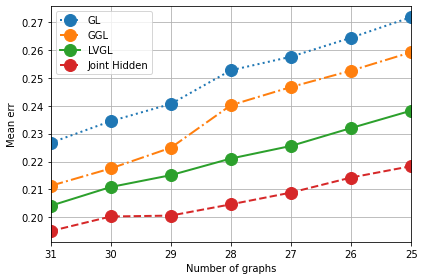

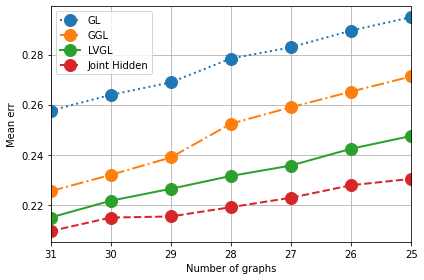

In [22]:
# GOOD PLOT IS THE SECOND ONE
err_mean = np.mean(err, axis=2)
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_sum_norm_mean = np.mean(err_sum_norm, axis=2)

# plot_err(OO, err_mean, 'Mean err', logy=False)  # without normalizing
plot_err(OO, err_mean_norm_mean, 'Mean err', logy=False)
plot_err(OO, err_sum_norm_mean, 'Mean err', logy=False)

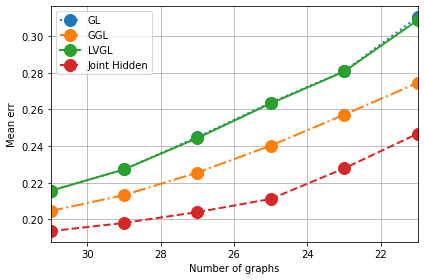

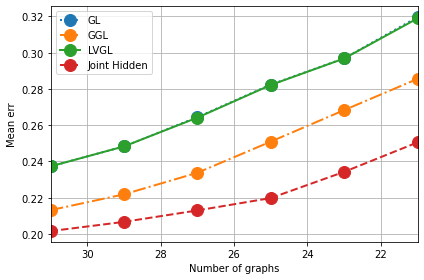

In [17]:
# GOOD PLOT IS THE SECOND ONE
err_mean = np.mean(err, axis=2)
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_sum_norm_mean = np.mean(err_sum_norm, axis=2)

# plot_err(OO, err_mean, 'Mean err', logy=False)  # without normalizing
plot_err(OO, err_mean_norm_mean, 'Mean err', logy=False)
plot_err(OO, err_sum_norm_mean, 'Mean err', logy=False)

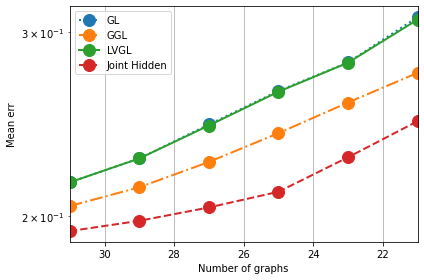

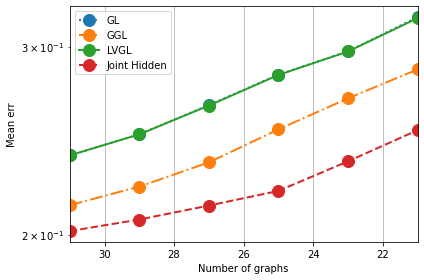

In [18]:
err_mean = np.mean(err, axis=2)
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_sum_norm_mean = np.mean(err_sum_norm, axis=2)

# plot_err(OO, err_mean, 'Mean err', logy=True)  # without normalizing
plot_err(OO, err_mean_norm_mean, 'Mean err', logy=True)
plot_err(OO, err_sum_norm_mean, 'Mean err', logy=True)

In [23]:
error_to_csv('data_Oexp_mean',['GL','GGL','LVGL','Joint'],np.array(OO),err_mean_norm_mean.T)
error_to_csv('data_Oexp_sum',['GL','GGL','LVGL','Joint'],np.array(OO),err_sum_norm_mean.T)

SAVED as: data_Oexp_mean
SAVED as: data_Oexp_sum
